### Gene expression vs 3D changes during Legionella infection
**cmdoret**


In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. I use differential expression results from [Li et al. 2020](https://www.frontiersin.org/articles/10.3389/fcimb.2020.00428/full#h4), and have lifted over the neff v1 annotations they used to the C3 genome.
> Note: I allowed multi-mapping, which means a single C3 gene can match multiple Neff gene and vice versa.

In [2]:
import os
import re
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import pyranges as pr
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
from pandarallel import pandarallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
from skimage import filters
import statsmodels.api as sm


os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [5]:
diff_expr = pd.read_csv('data/output/diff_expr/neffv1_liftoff_c3_de_genes.tsv', sep='\t')
liftover = pd.read_csv('data/tmp/liftoff/neffv1_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [6]:
liftover

,chrom,type,start,end,attr,accession,desc
0,scaffold_1,gene,517,5457,ID=gene:ACA1_272090;biotype=protein_coding;des...,ACA1_272090,Ras subfamily protein
40,scaffold_1,gene,6183,9815,ID=gene:ACA1_272100;biotype=protein_coding;des...,ACA1_272100,hypothetical protein
50,scaffold_1,gene,10749,11427,ID=gene:ACA1_272220;biotype=protein_coding;des...,ACA1_272220,hypothetical protein
60,scaffold_1,gene,30871,33218,ID=gene:ACA1_272240;biotype=protein_coding;des...,ACA1_272240,hypothetical protein
82,scaffold_1,gene,33329,33978,ID=gene:ACA1_272250;biotype=protein_coding;des...,ACA1_272250,hemerythrin hhe cation binding subfamily protein
...,...,...,...,...,...,...,...
213267,scaffold_90,gene,3593,4330,ID=gene:ACA1_374170;biotype=protein_coding;des...,ACA1_374170,hypothetical protein
213275,scaffold_90,gene,9190,9784,ID=gene:ACA1_374160;biotype=protein_coding;des...,ACA1_374160,hypothetical protein
213283,scaffold_93,gene,5734,6486,ID=gene:ACA1_045660;biotype=protein_coding;des...,ACA1_045660,hypothetical protein
213289,scaffold_93,gene,6787,6829,ID=gene:ACA1_263500;biotype=protein_coding;des...,ACA1_263500,polyprotein


In [7]:
print(f"{100* diff_expr.c3.isnull().sum() / diff_expr.shape[0]:.2f}% lifted-over genes had no 1:1 match in my de-novo annotation pipeline")

16.73% lifted-over genes had no 1:1 match in my de-novo annotation pipeline


First, let's visualize the differential expression of genes at 8h p.i. using a volcano plot:

<IPython.core.display.Javascript object>


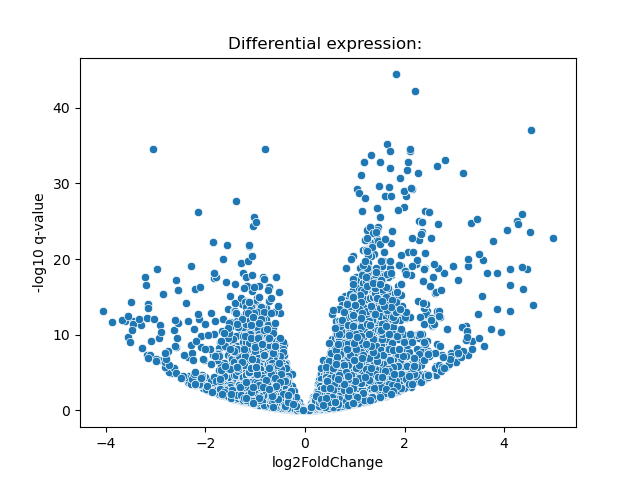

Text(0.5, 1.0, 'Differential expression: ')

In [5]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")
plt.title("Differential expression: ")

Let's subset genes which are highly differentially expressed at 8h p.i. This is the most similar timepoint to the Hi-C dataset (5h p.i.):


In [6]:
PADJ_THRESH = 0.05
L2FC_THRESH = 1

In [7]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [8]:
sig_expr = sig_expr.merge(liftover, on='accession', how='left').sort_values('padj')
sig_expr = sig_expr.dropna()
sig_expr.start = sig_expr.start.astype(int)
sig_expr.end = sig_expr.end.astype(int)
sig_expr = sig_expr.drop_duplicates(subset=['accession']).reset_index(drop=True)

In [9]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 1801 genes (9.71%)  with more than 1 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, notably ACA1_153540. Let's have a look at these.

In [10]:
sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]


,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,chrom,type,start,end,attr,desc
37,ACA1_153540,1458.066017,4.365291,0.388818,11.227093,3.001928e-29,1.057850e-26,VMHBD_08871,scaffold_24,gene,875568,878213,ID=gene:ACA1_153540;biotype=protein_coding;des...,"transcriptional regulator, Sir2 family protein"


It is indeed in our top differentially expressed gene list. 

For the next, preliminary analyses I will work with the subset of genes from scaffold_1 to avoid blowing up memory.

In [11]:
sub_genes = liftover.loc[liftover.chrom=='scaffold_1', :]

### Computing gene-based statistics from Hi-C data

So if we want to associate expression data to Hi-C data, we need to tie contact values to individual genes.
What I will do here is retrieve contact values between all pairs of genes before and after infection (2 replicates each). For every gene pair, I will then compute a contact change score (ratio, t-test, ...).
This will give us an interaction change network of NxN genes. I will then see how interaction change relate to co-expression using the RNAseq.


In [13]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/sub_uninfected.mcool::/resolutions/2000')
clr_inf = cooler.Cooler('data/output/cool/sub_infected.mcool::/resolutions/2000')

In [17]:
def get_contact_gene_pairs2(clr: cooler.Cooler, genes: pd.DataFrame, intra=False) -> pd.DataFrame:
    """ Compute average contacts between all gene pairs"""
    if intra:
        combs = []
        for chrom in clr.chroms()[:]['name']:
            combs += list(it.combinations(genes.accession[genes.chrom==chrom], 2))
        combs = pd.DataFrame((combs))
    else:
        combs = pd.DataFrame((it.combinations(genes.accession, 2)))
    combs.columns = ['g1', 'g2']
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g1')
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g2')    
    combs = combs.drop(columns=['g1', 'g2'])
    
    def avg_contacts(r):
        mat = clr.matrix(balance=True, sparse=False).fetch(
            f'{r.chrom_x}:{r.start_x}-{r.end_x}',
            f'{r.chrom_y}:{r.start_y}-{r.end_y}'
        )
        return np.nanmean(mat)
    mean_contacts = combs.parallel_apply(avg_contacts, axis=1)
    combs['mean_contacts'] = mean_contacts
    return combs
    

Now I compute average contacts between all pairs of genes.

In [18]:
#p_hic = get_contact_gene_pairs('data/output/cool/sub_uninfected.mcool::/resolutions/2000', sub_genes)

pandarallel.initialize(progress_bar=True)
p_hic = get_contact_gene_pairs2(clr_ctl, sub_genes, intra=True)
p_hic = (
    p_hic
    .rename(columns=lambda c: re.sub(r'_x$', '1', c))
    .rename(columns=lambda c: re.sub(r'_y$', '2', c))
)
p_hic = p_hic.rename(columns={'mean_contacts': 'ctl_contacts'})
p_hic['inf_contacts'] = get_contact_gene_pairs2(clr_inf, sub_genes, intra=True)['mean_contacts']


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


When visualising the results, it seems that genes differentially expressed at 8h p.i. do not have stronger contacts change during infection than the rest of the genome. The histogram below shows the proportion of contact change during infection (5h pi).

> Note: Only gene pairs where both genes have nonzero contacts in both conditions (uninfected or infected) were shown.

In [19]:
p_hic.head()

,chrom1,start1,end1,accession1,chrom2,start2,end2,accession2,ctl_contacts,inf_contacts
0,scaffold_1,517,5457,ACA1_272090,scaffold_1,6183,9815,ACA1_272100,0.042838,0.031010
1,scaffold_1,517,5457,ACA1_272090,scaffold_1,10749,11427,ACA1_272220,0.038855,0.030869
2,scaffold_1,6183,9815,ACA1_272100,scaffold_1,10749,11427,ACA1_272220,0.039766,0.037309
3,scaffold_1,517,5457,ACA1_272090,scaffold_1,30871,33218,ACA1_272240,0.011830,0.006955
4,scaffold_1,6183,9815,ACA1_272100,scaffold_1,30871,33218,ACA1_272240,0.022390,0.012364


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


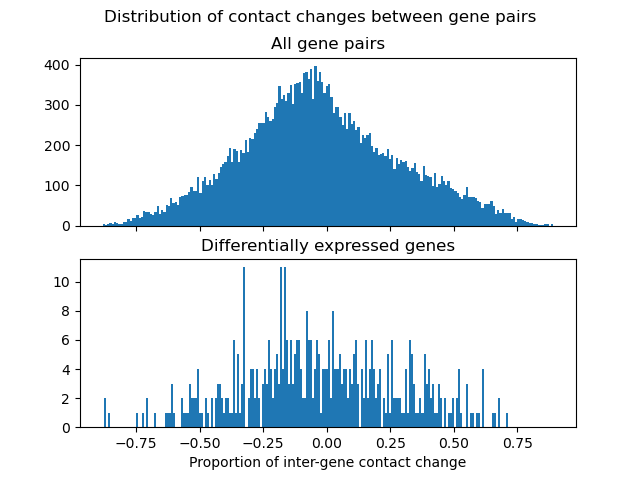

Text(0.5, 0, 'Proportion of inter-gene contact change')

In [20]:
%matplotlib notebook
de_nnz_hic = p_hic.loc[
    p_hic.accession1.isin(sig_expr.accession) &
    p_hic.accession2.isin(sig_expr.accession) &
    (p_hic.inf_contacts > 0) &
    (p_hic.ctl_contacts > 0),
    :
]
de_nnz_hic.prop_change = (de_nnz_hic.inf_contacts - de_nnz_hic.ctl_contacts) / (de_nnz_hic.inf_contacts + de_nnz_hic.ctl_contacts)

nnz_hic = p_hic.loc[(p_hic.ctl_contacts > 0) & (p_hic.inf_contacts) > 0, :]
nnz_hic.prop_change = (nnz_hic.inf_contacts - nnz_hic.ctl_contacts) / (nnz_hic.inf_contacts + nnz_hic.ctl_contacts)

fig, ax = plt.subplots(2, 1, sharex=True)
f = ax[0].hist(
    (nnz_hic.prop_change),
    200
)
f = ax[1].hist(
    (de_nnz_hic.prop_change),
    200
)


plt.suptitle("Distribution of contact changes between gene pairs")
ax[0].set_title("All gene pairs")
ax[1].set_title("Differentially expressed genes")
ax[1].set_xlabel('Proportion of inter-gene contact change')

In [21]:
print(
    f'The differentially expressed do not have significantly stronger contact changes than the rest of the genome. Mann whitney U : {ss.mannwhitneyu(abs(nnz_hic.prop_change), abs(de_nnz_hic.prop_change))}'
)

The differentially expressed do not have significantly stronger contact changes than the rest of the genome. Mann whitney U : MannwhitneyuResult(statistic=6178019.5, pvalue=0.1659509323431132)


In [22]:
nnz_gene_pairs = nnz_hic.shape[0]
nnz_inter_pairs = nnz_hic.loc[nnz_hic.chrom1 != nnz_hic.chrom2, :].shape[0]
print(f'There are {nnz_gene_pairs} gene pairs with nonzero contacts (out of {p_hic.shape[0]}).'
      f' {nnz_inter_pairs} of these are interchromosomal'
)

There are 27771 gene pairs with nonzero contacts (out of 353220). 0 of these are interchromosomal


In [23]:
import re
p_hic_sym = pd.concat([
    p_hic, (
    p_hic
    .rename(columns=lambda c: re.sub(r'1$', r'3', c))
    .rename(columns=lambda c: re.sub(r'2$', r'1', c))
    .rename(columns=lambda c: re.sub(r'3$', r'2', c))
    .loc[:, p_hic.columns]
    )]
)

When visualizing the pairwise gene-gene contact matrix, we see clusters appearing along the diagonal.
This confirms that genes closer to each other make more contacts with each other (after detrending for diagonal gradient). This suggest they are involved in some sort of contact domains

<IPython.core.display.Javascript object>


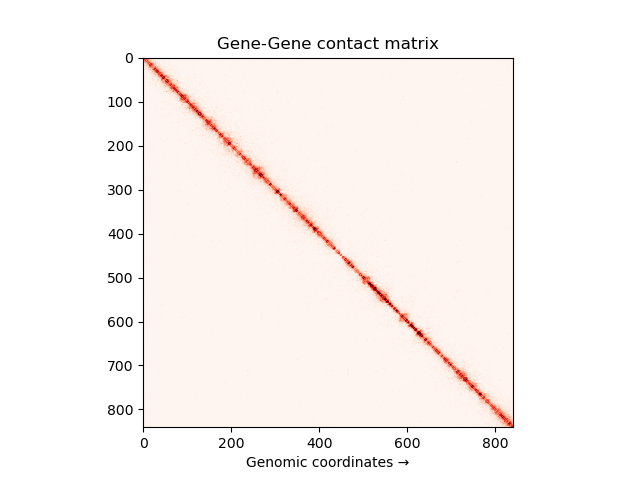

Text(0.5, 0, 'Genomic coordinates →')

In [24]:
%matplotlib notebook
hic_mat = (
    p_hic_sym
    .sort_values(['chrom1', 'start1', 'chrom2', 'start2'])
    .loc[:, ['accession1', 'accession2', 'ctl_contacts']]
    .pivot('accession1', 'accession2')
    .fillna(0)
)
hic_mat.columns = [o[1] for o in hic_mat.columns]
ord_genes = [g for g in liftover.sort_values(['chrom', 'start']).accession if g in hic_mat.columns]
hic_mat = hic_mat.loc[ord_genes, :].loc[:, ord_genes]
hic_mat = hic_mat.to_numpy() + hic_mat.to_numpy().T
plt.imshow(np.log1p(hic_mat), vmax = np.percentile(hic_mat, 99.8), cmap='Reds')
plt.title('Gene-Gene contact matrix')
plt.xlabel('Genomic coordinates →')

We can also visualize the detrended contacts vs genomic distance plot, showing a contact enrichment between pairs of genes spaced by ~10kb.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


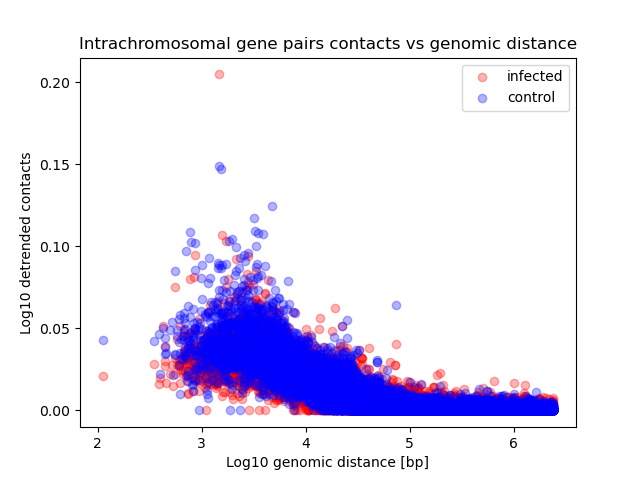

In [25]:
%matplotlib notebook
cis_hic = p_hic.loc[p_hic.chrom1 == p_hic.chrom2, :]
plt.scatter(np.log10(abs(cis_hic.start2 - cis_hic.start1)), cis_hic.inf_contacts, c='red', alpha=0.3, label='infected')
plt.scatter(np.log10(abs(cis_hic.start2 - cis_hic.start1)), cis_hic.ctl_contacts, c='blue', alpha=0.3, label='control')
plt.title("Intrachromosomal gene pairs contacts vs genomic distance")
plt.ylabel("Log10 detrended contacts")
plt.xlabel("Log10 genomic distance [bp]")
plt.legend()

#### Co-variation of gene expression over time

I have formatted the data from Li et al to get the expression of each gene at each timepoint.
First, let's visualize the co-expression of all genes across the 4 time points.


In [26]:
expr_time = pd.read_csv('data/output/diff_expr/li2020_expr_vs_time.tsv', sep='\t')

In [27]:
#expr_time['expr'] = 2**expr_time.log2FoldChange *   expr_time.baseMean
expr_time['expr'] = expr_time['log2FoldChange']

In [28]:
def expr_to_corr(df):
    """Convert time vs expression df to correlation matrix"""
    mat = df.loc[:, ['accession', 'time', 'expr']].pivot('accession', 'time')
    mat.columns = mat.columns.get_level_values(1)
    mat.columns.name = None
    mat = mat.dropna(axis=0)
    corr = mat.transpose().corr().fillna(0)
    
    return corr

corr_mat = expr_to_corr(expr_time)


Here, I cluster all genes along the co-expression matrix using hierarchical clustering. We can see the emergence of two large modules of antagonist genes, and several smaller groups.

In [29]:

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [ ]:
%matplotlib notebook

plt.imshow(cluster_corr(corr_mat), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Co-expression matrix, whole transcriptome")
plt.colorbar()

Here, I use the gene subset defined previously to make analyses faster. 

In [30]:
def corr_to_long(corr):
    """Given a correlation matrix, generate the long format dataframe of the upper triangle."""
    corr.index = corr.index.rename('accession1')
    lcorr = corr.stack().reset_index()
    lcorr = lcorr.rename(columns={'accession': 'accession2', 0: 'coexpr'})
    lower = lcorr.accession1 > lcorr.accession2
    lcorr.accession1[lower], lcorr.accession2[lower] = lcorr.accession2[lower], lcorr.accession1[lower]
    lcorr = lcorr.drop_duplicates(subset=['accession1', 'accession2'])
    
    return lcorr

#corr_sig = expr_to_corr(expr_time.loc[expr_time.accession.isin(sig_expr.accession)])
corr_sub = expr_to_corr(
    expr_time.loc[
        expr_time.accession.isin(sub_genes.accession), :
    ].reset_index(drop=True)
)

long_corr_upper = corr_to_long(corr_sub)


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


The co-expression matrix now looks much simpler. We still see two main clusters.

<IPython.core.display.Javascript object>


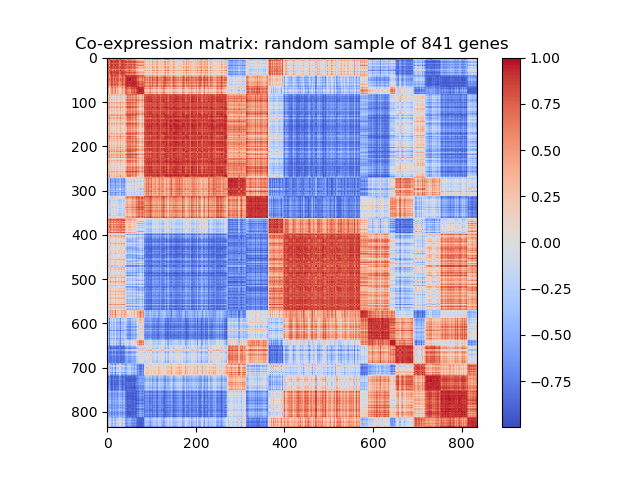

Text(0.5, 1.0, 'Co-expression matrix: random sample of 841 genes')

In [33]:
%matplotlib notebook
plt.imshow(cluster_corr(corr_sub), cmap='coolwarm')
plt.colorbar()
plt.title(f"Co-expression matrix: random sample of {sub_genes.accession.shape[0]} genes")

We previously saw that gene-gene contacts seem to correlate well with genomic position.
Does it hold for co-expression as well ? (Closer genes are regulated together)

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


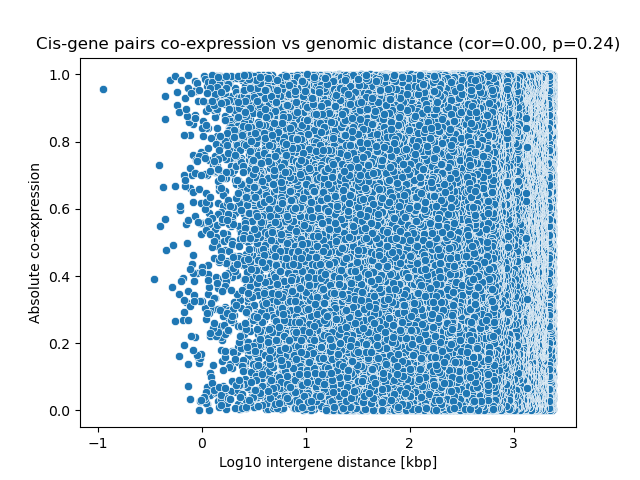

Text(0, 0.5, 'Absolute co-expression')

In [34]:
%matplotlib notebook

cis = long_corr_upper.merge(
    (liftover
         .loc[:, ['accession', 'chrom', 'start']]
         .rename(columns={'accession': 'accession1', 'chrom': 'chrom1', 'start': 'start1'})
    ),
    on='accession1',
    how='left',
).merge(
    (liftover
        .loc[:, ['accession', 'chrom', 'start']]
        .rename(columns={'accession': 'accession2', 'chrom': 'chrom2', 'start': 'start2'})
    ),
    on='accession2',
    how='left',
)
cis = cis.loc[(cis.chrom1 == cis.chrom2), :]
sns.scatterplot(np.log10(abs(cis.start2 - cis.start1)/1000), cis.coexpr.abs())
#sns.kdeplot(np.log10(abs(cis.start2 - cis.start1)/1000), abs(cis.coexpr), color='red', alpha=0.5)
cor = ss.pearsonr(abs(cis.start2 - cis.start1)/1000, abs(cis.coexpr))
plt.title(f'Cis-gene pairs co-expression vs genomic distance (cor={cor[0]:.2f}, p={cor[1]:.2f})')
plt.xlabel("Log10 intergene distance [kbp]")
plt.ylabel("Absolute co-expression")

#### Combining inter-gene contacts and co-expression data
Now let's plug in the Hi-C contact changes with co-expression data ! I still work with the random subset.

In [35]:
# Compute proportion of contact change during infection for each pair of genes
hic_rna = p_hic.merge(long_corr_upper, on=['accession1', 'accession2'], how='inner')
hic_rna['contacts_change'] = (hic_rna.inf_contacts - hic_rna.ctl_contacts) / (hic_rna.inf_contacts + hic_rna.ctl_contacts)
#hic_rna = hic_rna.loc[hic_rna.contacts_change > -1, :]

After removing genes with 0 contacts, we see that the distribution of co-expression follows a bimodal distribution, whereas the contacts distribution is ~ gaussian with a long right tail. There does not seem to be a global correlation between contact and co-expression during infection, but we see some "outlier" density spots of highly coexpressed genes with more contacts.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


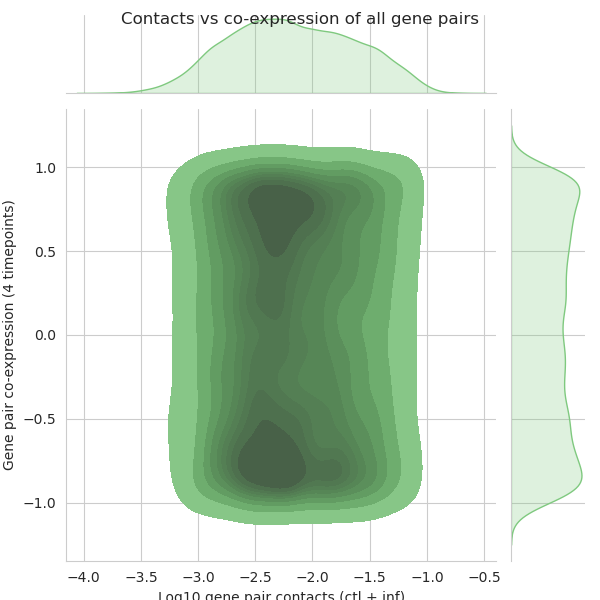

In [38]:
%matplotlib notebook
# Dropping all gene pairs where at least one gene has zero contacts
hr_clean = hic_rna.dropna().loc[
    (hic_rna.ctl_contacts > 0) &
    (hic_rna.inf_contacts > 0), :
]
with sns.axes_style("whitegrid"):
    sns.set_palette("Accent")
    jp = sns.jointplot(np.log10(hr_clean.inf_contacts + hr_clean.ctl_contacts), hr_clean.coexpr, kind='kde', fill=True)
    plt.suptitle('Contacts vs co-expression of all gene pairs')
    jp.ax_joint.set_xlabel('Log10 gene pair contacts (ctl + inf)')
    jp.ax_joint.set_ylabel('Gene pair co-expression (4 timepoints)')

If we restrict this analysis to intrachromosomal gene pairs, the contact distribution becomes bimodal as well. Hinting there is a subgroup of gene pairs with a higher contact density.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


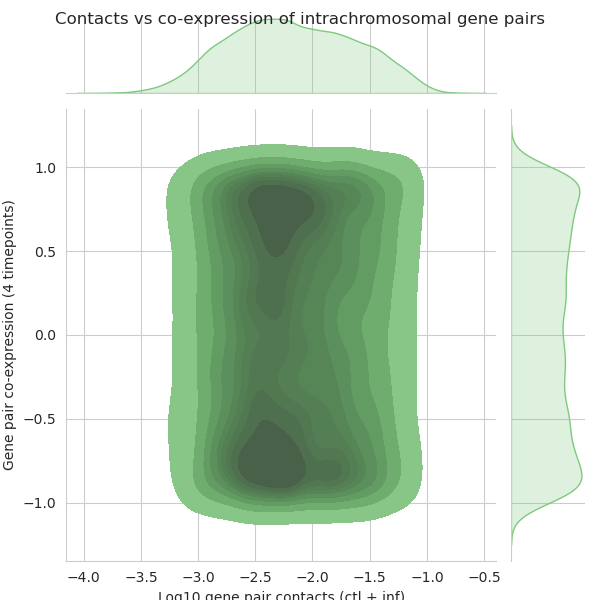

In [39]:
%matplotlib notebook
# Dropping all gene pairs where at least one gene has zero contacts
hr_clean_intra = hic_rna.dropna().loc[
    (hic_rna.ctl_contacts > 0) &
    (hic_rna.inf_contacts > 0) &
    (hic_rna.chrom1==hic_rna.chrom2), :
]
with sns.axes_style("whitegrid"):
    sns.set_palette("Accent")
    jp = sns.jointplot(
        np.log10(hr_clean_intra.inf_contacts + hr_clean_intra.ctl_contacts),
        hr_clean_intra.coexpr, kind='kde', fill=True
    )
    plt.suptitle('Contacts vs co-expression of intrachromosomal gene pairs')
    jp.ax_joint.set_xlabel('Log10 gene pair contacts (ctl + inf)')
    jp.ax_joint.set_ylabel('Gene pair co-expression (4 timepoints)')

In [42]:
import scipy.stats as ss
ss.pearsonr(hr_clean.coexpr.abs(), np.log(hr_clean.inf_contacts+hr_clean.ctl_contacts))

(0.021052877282657662, 0.0021267755345099983)

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


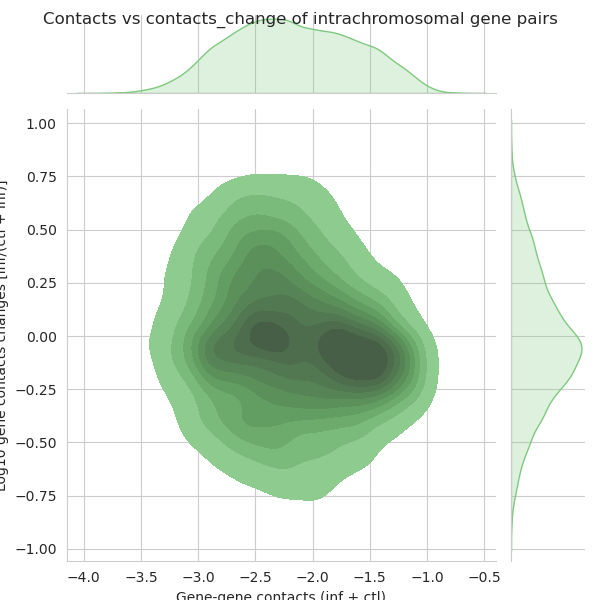

In [43]:
%matplotlib notebook
# Dropping all gene pairs where at least one gene has zero contacts
hr_clean_intra = hic_rna.dropna().loc[
    (hic_rna.ctl_contacts > 0) &
    (hic_rna.inf_contacts > 0) &
    (hic_rna.chrom1==hic_rna.chrom2), :
]
with sns.axes_style("whitegrid"):
    sns.set_palette("Accent")
    jp = sns.jointplot(
        np.log10(hr_clean_intra.inf_contacts + hr_clean_intra.ctl_contacts),
        hr_clean_intra.contacts_change, kind='kde', fill=True
    )
    plt.suptitle('Contacts vs contacts_change of intrachromosomal gene pairs')
    jp.ax_joint.set_ylabel('Log10 gene contacts changes [inf/(ctl + inf)]')
    jp.ax_joint.set_xlabel('Gene-gene contacts (inf + ctl)')

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


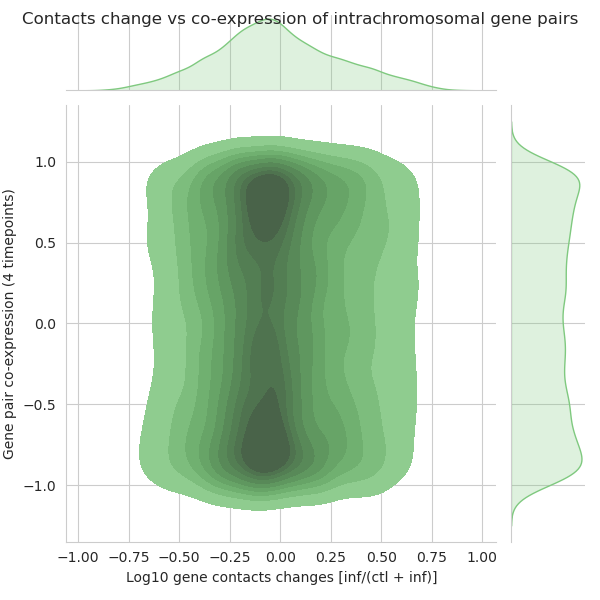

In [44]:
%matplotlib notebook
with sns.axes_style("whitegrid"):
    sns.set_palette("Accent")
    jp = sns.jointplot(
        hr_clean_intra.contacts_change,
        hr_clean_intra.coexpr, kind='kde', fill=True
    )
    plt.suptitle('Contacts change vs co-expression of intrachromosomal gene pairs')
    jp.ax_joint.set_xlabel('Log10 gene contacts changes [inf/(ctl + inf)]')
    jp.ax_joint.set_ylabel('Gene pair co-expression (4 timepoints)')

In [209]:
ss.spearmanr(hr_clean.coexpr, hr_clean.contacts_change)

SpearmanrResult(correlation=0.01589977593868033, pvalue=0.020345906152573447)

In [36]:
liftover

,chrom,type,start,end,attr,accession,desc
0,scaffold_1,gene,517,5457,ID=gene:ACA1_272090;biotype=protein_coding;des...,ACA1_272090,Ras subfamily protein
40,scaffold_1,gene,6183,9815,ID=gene:ACA1_272100;biotype=protein_coding;des...,ACA1_272100,hypothetical protein
50,scaffold_1,gene,10749,11427,ID=gene:ACA1_272220;biotype=protein_coding;des...,ACA1_272220,hypothetical protein
60,scaffold_1,gene,30871,33218,ID=gene:ACA1_272240;biotype=protein_coding;des...,ACA1_272240,hypothetical protein
82,scaffold_1,gene,33329,33978,ID=gene:ACA1_272250;biotype=protein_coding;des...,ACA1_272250,hemerythrin hhe cation binding subfamily protein
...,...,...,...,...,...,...,...
213267,scaffold_90,gene,3593,4330,ID=gene:ACA1_374170;biotype=protein_coding;des...,ACA1_374170,hypothetical protein
213275,scaffold_90,gene,9190,9784,ID=gene:ACA1_374160;biotype=protein_coding;des...,ACA1_374160,hypothetical protein
213283,scaffold_93,gene,5734,6486,ID=gene:ACA1_045660;biotype=protein_coding;des...,ACA1_045660,hypothetical protein
213289,scaffold_93,gene,6787,6829,ID=gene:ACA1_263500;biotype=protein_coding;des...,ACA1_263500,polyprotein


Are gene on the same chromosome more co-regulated ?
No

<IPython.core.display.Javascript object>


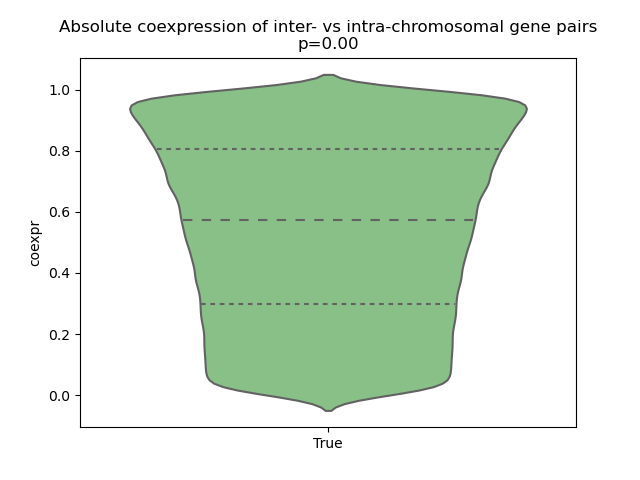

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


Text(0.5, 1.0, 'Absolute coexpression of inter- vs intra-chromosomal gene pairs\np=0.00')

In [45]:
%matplotlib notebook
sns.violinplot(x=hic_rna.chrom1 == hic_rna.chrom2, y=np.abs(hic_rna.coexpr), inner='quart')
intra_inter_coexpr = ss.mannwhitneyu(
    hic_rna.coexpr[hic_rna.chrom1 == hic_rna.chrom2],
    hic_rna.coexpr[hic_rna.chrom1 != hic_rna.chrom2])
plt.title(f"Absolute coexpression of inter- vs intra-chromosomal gene pairs\np={intra_inter_coexpr[1]:.2f}")

### Impact of domains on coexpression

In mammals, genes within the same TAD are usually co-regulated. Here, I assess whether genes in the same contact domain (predetected using chromosight) are more co-expressed than others.

In [46]:
# Load domains coordinates
domains = pd.read_csv('tmp/domains.tsv', sep='\t')
# Combine (merge) overlapping domains
domains = pr.PyRanges(
    (domains
        .loc[:, ['chrom1', 'start1', 'start2', 'corner_id']]
        .rename(columns={'chrom1': 'Chromosome', 'start1': 'Start', 'start2': 'End'})
    )
)
# Assign a unique ID to every non overlapping domain
domains = domains.sort().insert(pd.Series(domains.df.index.values, name='domain_id'))

In [47]:
domains.df

,Chromosome,Start,End,corner_id,domain_id
0,scaffold_1,12000,124000,2,0
1,scaffold_1,56000,188000,4,1
2,scaffold_1,64000,188000,4,2
3,scaffold_1,124000,224000,7,3
4,scaffold_1,124000,232000,7,4
...,...,...,...,...,...
843,scaffold_34,260000,280000,1737,843
844,scaffold_35,92000,124000,1743,844
845,scaffold_35,100000,124000,1743,845
846,scaffold_35,124000,200000,1744,846


In [48]:
# Get overlap between left genes and domains
rna1 = pr.PyRanges((hic_rna
    .loc[:, ['chrom1', 'start1', 'end1', 'accession1', 'accession2']]
    .rename(columns={'chrom1': 'Chromosome', 'start1': 'Start', 'end1': 'End'})))
# Get overlaps between right genes and domains
rna2 = pr.PyRanges((hic_rna
    .loc[:, ['chrom2', 'start2', 'end2', 'accession1', 'accession2']]
    .rename(columns={'chrom2': 'Chromosome', 'start2': 'Start', 'end2': 'End'})))


In [49]:
import re
# Merge left- and right-gene overlaps by pair
domain_pairs = pd.merge(
    rna1.join(domains, how='containment').df,
    rna2.join(domains, how='containment').df,
    on=['accession1', 'accession2'],
    suffixes=['1', '2']
)

# remove extra columns from resulting structure
domain_pairs = domain_pairs.loc[:, ['accession1', 'accession2', 'domain_id1', 'domain_id2']]
# Add domain information to the original structure
domain_pairs = domain_pairs.merge(hic_rna, on=['accession1', 'accession2'])
domain_pairs = domain_pairs.loc[domain_pairs.chrom1 == domain_pairs.chrom2, :]

In [50]:
domain_pairs

,accession1,accession2,domain_id1,domain_id2,chrom1,start1,end1,chrom2,start2,end2,ctl_contacts,inf_contacts,coexpr,contacts_change
0,ACA1_272240,ACA1_272250,0,0,scaffold_1,30871,33218,scaffold_1,33329,33978,0.013127,0.029010,0.799669,0.376951
1,ACA1_272240,ACA1_272260,0,0,scaffold_1,30871,33218,scaffold_1,34310,36198,0.031443,0.029317,-0.152684,-0.034994
2,ACA1_272250,ACA1_272260,0,0,scaffold_1,33329,33978,scaffold_1,34310,36198,0.029178,0.025714,0.169223,-0.063106
3,ACA1_272240,ACA1_272270,0,0,scaffold_1,30871,33218,scaffold_1,36454,40425,0.024905,0.026389,-0.104080,0.028942
4,ACA1_272250,ACA1_272270,0,0,scaffold_1,33329,33978,scaffold_1,36454,40425,0.025781,0.022391,-0.620295,-0.070377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466027,ACA1_167070,ACA1_194880,36,36,scaffold_1,2314921,2321851,scaffold_1,2398323,2399921,0.000000,0.001584,0.724837,1.000000
466028,ACA1_167080,ACA1_194880,36,36,scaffold_1,2324731,2325530,scaffold_1,2398323,2399921,0.000000,0.000000,-0.919548,NaN
466029,ACA1_167090,ACA1_194880,36,36,scaffold_1,2325699,2326682,scaffold_1,2398323,2399921,0.000000,0.000000,-0.237168,NaN
466030,ACA1_167100,ACA1_194880,36,36,scaffold_1,2327919,2329452,scaffold_1,2398323,2399921,0.000000,0.000000,-0.277315,NaN


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(27.0, 0.5, 'Inter-gene distance')

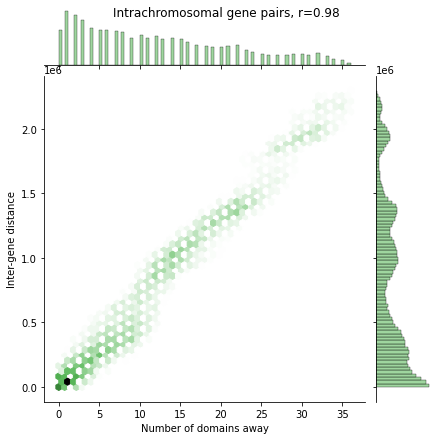

In [72]:
%matplotlib inline
gg_dist = abs(domain_pairs.start2 - domain_pairs.start1)
n_doms = abs(domain_pairs.domain_id2 - domain_pairs.domain_id1)

sns.jointplot(n_doms, gg_dist, kind='hex')

plt.suptitle(
    f'Intrachromosomal gene pairs, r={ss.pearsonr(n_doms, gg_dist)[0]:.2f}'
)
plt.xlabel("Number of domains away")
plt.ylabel("Inter-gene distance")

In [52]:
print(np.mean(abs(domain_pairs.ctl_contacts[domain_pairs.domain_id1 != domain_pairs.domain_id2])))
print(np.mean(abs(domain_pairs.ctl_contacts[domain_pairs.domain_id1 == domain_pairs.domain_id2])))

0.000782374358294182
0.009618621579728861


Subset gene pairs within distance ~= the size of a domain to compare genes pairs in the same distance range.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


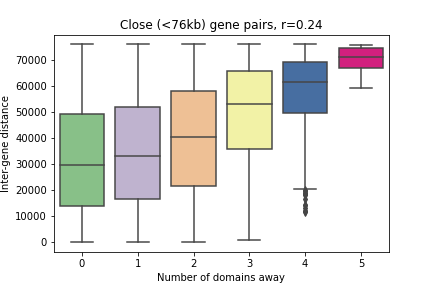

In [77]:
%matplotlib notebook
domain_size = np.median(domains.df.End - domains.df.Start)
close_pairs = domain_pairs.query(
    '(chrom1 == chrom2) & ((start2 - start1) < @domain_size)'
)
gg_dist = abs(close_pairs.start2 - close_pairs.start1)
n_doms = abs(close_pairs.domain_id2 - close_pairs.domain_id1)
sns.boxplot(n_doms, gg_dist)

plt.title(
    f'Close (<{int(domain_size)//1000}kb) gene pairs, r={ss.pearsonr(n_doms, gg_dist)[0]:.2f}'
)
plt.xlabel("Number of domains away")
plt.ylabel("Inter-gene distance")

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


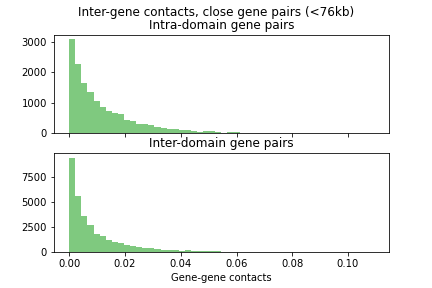

In [79]:
%matplotlib notebook

close_pairs['intra_domain'] = [
    'intra' if i else 'inter' for i in close_pairs.domain_id1 == close_pairs.domain_id2]

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].hist(
    close_pairs.ctl_contacts[close_pairs.intra_domain == 'intra'].abs(),
    50
)
ax[0].set_title("Intra-domain gene pairs")
ax[1].hist(
    close_pairs.ctl_contacts[close_pairs.intra_domain == 'inter'].abs(),
    50
)
ax[1].set_title("Inter-domain gene pairs")
ax[1].set_xlabel("Gene-gene contacts")
plt.suptitle(f"Inter-gene contacts, close gene pairs (<{int(domain_size//1000)}kb)")

In [80]:
pval = ss.mannwhitneyu(
    close_pairs.ctl_contacts[close_pairs.intra_domain=='intra'],
    close_pairs.ctl_contacts[close_pairs.intra_domain=='inter']
)[1]
print(
    f'Intra-domain gene pairs have more contacts have more contacts than inter-domain gene pairs: p={pval:.2e}'
)

Intra-domain gene pairs have more contacts have more contacts than inter-domain gene pairs: p=7.43e-188


<IPython.core.display.Javascript object>


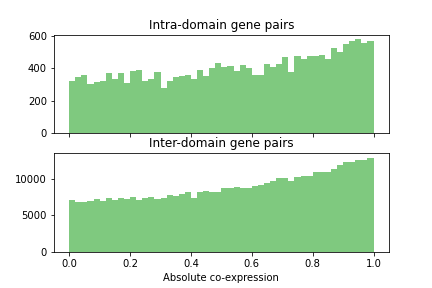

In [82]:
%matplotlib notebook

domain_pairs['intra_domain'] = [
    'intra' if i else 'inter' for i in domain_pairs.domain_id1 == domain_pairs.domain_id2]

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].hist(
    domain_pairs.coexpr[domain_pairs.intra_domain == 'intra'].abs(),
    50
)
ax[0].set_title("Intra-domain gene pairs")
ax[1].hist(
    domain_pairs.coexpr[domain_pairs.intra_domain == 'inter'].abs(),
    50
)
ax[1].set_xlabel("Absolute co-expression")
ax[1].set_title("Inter-domain gene pairs")

It seems that genes within the same TAD are not more co-expressed than genes between different TADs.

In [85]:
pval = ss.mannwhitneyu(
    close_pairs.coexpr[close_pairs.intra_domain == 'intra'].abs(),
    close_pairs.coexpr[close_pairs.intra_domain == 'inter'].abs()
)[1]
print(f'Genes within the same domain are not more co-expressed than genes between different TADs p={pval:.2f}')

Genes within the same domain are not more co-expressed than genes between different TADs p=0.50


In [60]:
close_pairs

,accession1,accession2,domain_id1,domain_id2,chrom1,start1,end1,chrom2,start2,end2,ctl_contacts,inf_contacts,coexpr,contacts_change,intra_domain
0,ACA1_272240,ACA1_272250,0,0,scaffold_1,30871,33218,scaffold_1,33329,33978,0.013127,0.029010,0.799669,0.376951,intra
1,ACA1_272240,ACA1_272260,0,0,scaffold_1,30871,33218,scaffold_1,34310,36198,0.031443,0.029317,-0.152684,-0.034994,intra
2,ACA1_272250,ACA1_272260,0,0,scaffold_1,33329,33978,scaffold_1,34310,36198,0.029178,0.025714,0.169223,-0.063106,intra
3,ACA1_272240,ACA1_272270,0,0,scaffold_1,30871,33218,scaffold_1,36454,40425,0.024905,0.026389,-0.104080,0.028942,intra
4,ACA1_272250,ACA1_272270,0,0,scaffold_1,33329,33978,scaffold_1,36454,40425,0.025781,0.022391,-0.620295,-0.070377,intra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465588,ACA1_167110,ACA1_194890,36,36,scaffold_1,2329637,2331771,scaffold_1,2393730,2397058,0.000948,0.001624,-0.989382,0.262583,intra
466028,ACA1_167080,ACA1_194880,36,36,scaffold_1,2324731,2325530,scaffold_1,2398323,2399921,0.000000,0.000000,-0.919548,NaN,intra
466029,ACA1_167090,ACA1_194880,36,36,scaffold_1,2325699,2326682,scaffold_1,2398323,2399921,0.000000,0.000000,-0.237168,NaN,intra
466030,ACA1_167100,ACA1_194880,36,36,scaffold_1,2327919,2329452,scaffold_1,2398323,2399921,0.000000,0.000000,-0.277315,NaN,intra


As an attempt to decouple genomic distance from domains, I will use a linear model to extract the specific effect of the domain-distance factor.

In [61]:
close_pairs['dom_dist'] = abs(close_pairs.domain_id2 - close_pairs.domain_id1)
close_pairs['bp_dist'] = abs(close_pairs.start2 - close_pairs.start1)
tbl_pairs = close_pairs.loc[:, ['dom_dist', 'bp_dist', 'coexpr']].dropna()
tbl_pairs.head()

y = tbl_pairs['coexpr'].abs()
X = tbl_pairs.loc[:, ['dom_dist', 'bp_dist']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 coexpr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.534
Date:                Thu, 12 Aug 2021   Prob (F-statistic):             0.0107
Time:                        15:19:45   Log-Likelihood:                -8815.7
No. Observations:               47728   AIC:                         1.764e+04
Df Residuals:                   47725   BIC:                         1.766e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5422      0.003    194.611      0.000       0.537       0.548
dom_dist      -0.0010      0.001     -0.714      0.475      -0.004       0.002
bp_dist      1.91e-07   6.34e-08      3.011      0.003    6.67e-08    3.15e-07
==============================================================================
Omnibus:                    34857.674   Durbin-Watson:                   0.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3084.936
Skew:                          -0.203   Prob(JB):                         0.00
Kurtosis:                       1.823   Cond. No.                     9.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given the collinearity between explanatory variables, coefficients may be inaccurate, however it is clear that genomic distance has an impact on absolute coexpression, while domain membership does not.

In [285]:
tbl_pairs

,dom_dist,bp_dist,coexpr
0,0,2458,0.799669
1,0,3439,-0.152684
2,0,981,0.169223
3,0,5583,-0.104080
4,0,3125,-0.620295
...,...,...,...
465588,0,64093,-0.989382
466028,0,73592,-0.919548
466029,0,72624,-0.237168
466030,0,70404,-0.277315


#### Impact of telomere distance
Another set of genes which may be interesting are those located near telomeres, since telomeres seem to form specific interchromosomal contacts and that these contacts are altered during infection

In [62]:
def add_teldist(df, chroms):
    df1 = (
        df
            .merge(chroms, left_on='chrom1', right_on='name', how='inner')
            .drop(columns=['name'])
            .rename(columns={'length': 'teldist1'})
    )
    df1 = (
        df1.merge(chroms, left_on='chrom2', right_on='name', how='inner')
            .drop(columns=['name'])
            .rename(columns={'length': 'teldist2'})
    )
    
    first_half = df1.start1 < (df1.teldist1//2)
    df1.teldist1[first_half] = df1.start1[first_half] / df1.teldist1[first_half]
    df1.teldist1[~first_half] = (df1.teldist1[~first_half] - df1.start1[~first_half]) / df1.teldist1[~first_half]
    first_half = df1.start2 < (df1.teldist2//2)
    df1.teldist2[first_half] = df1.start2[first_half] / df1.teldist2[first_half]
    df1.teldist2[~first_half] = (df1.teldist2[~first_half] - df1.start2[~first_half]) / df1.teldist2[~first_half]
    return df1
hr_tel = add_teldist(hic_rna, clr_ctl.chroms()[:])

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


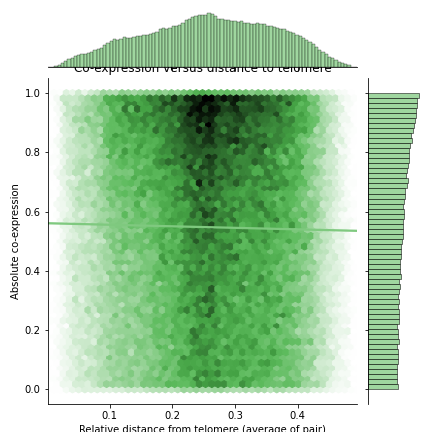

Text(0.5, 1.0, 'Co-expression versus distance to telomere')

In [63]:
%matplotlib notebook
#sns.kdeplot(hr_tel.teldist1 + hr_tel.teldist2, hr_tel.coexpr.abs())
g = sns.jointplot(x=(hr_tel.teldist1 + hr_tel.teldist2)/2, y=hr_tel.coexpr.abs(), kind='hex')
g.plot_joint(sns.regplot, scatter=False)
plt.xlabel("Relative distance from telomere (average of pair)")
plt.ylabel("Absolute co-expression")
plt.title("Co-expression versus distance to telomere")

<IPython.core.display.Javascript object>


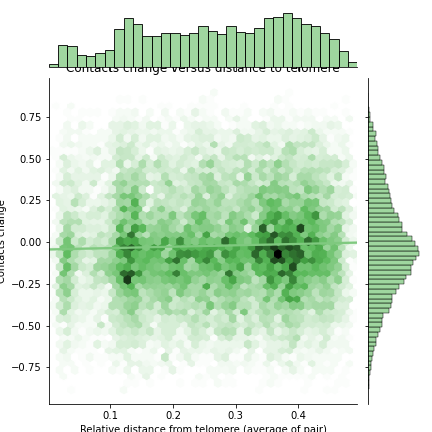

Text(0.5, 1.0, 'Contacts change versus distance to telomere')

In [64]:
%matplotlib notebook
#sns.kdeplot(hr_tel.teldist1 + hr_tel.teldist2, hr_tel.coexpr.abs())
tc = hr_tel.loc[(hr_tel.ctl_contacts > 0) & (hr_tel.inf_contacts > 0), :]
g = sns.jointplot(x=(tc.teldist1 + tc.teldist2)/2, y=tc.contacts_change, kind='hex')
g.plot_joint(sns.regplot, scatter=False)
plt.xlabel("Relative distance from telomere (average of pair)")
plt.ylabel("Contacts change")
plt.title("Contacts change versus distance to telomere")

In [65]:
ss.pearsonr((tc.teldist1 + tc.teldist2)/2, tc.contacts_change)

(0.03292843204319547, 1.543449410448614e-06)

#### Subsetting specific genes
Although I did not find a global relationship between inter-gene contacts and co-expression, we can still look at the annotations of the small subset of genes that are both differentially expressed and have contacts changes.

From here on, I do work with all intrachromosomal gene pairs instead of a random subset.

In [14]:
p_hic = get_contact_gene_pairs('data/output/cool/uninfected_merged_subsampled.cool', liftover, intra=True)
p_hic = p_hic.rename(columns={'mean_contacts': 'ctl_contacts'})
p_hic['inf_contacts'] = get_contact_gene_pairs('data/output/cool/infected_merged_subsampled.cool', liftover, intra=True)['mean_contacts']


max_perc_undetected set to 50.0 based on config file.
Matrix already balanced, reusing weights
Found 22005 / 22111 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpmp_c5hnr/curr.pdf
max_perc_undetected set to 50.0 based on config file.
Matrix already balanced, reusing weights
Found 22020 / 22111 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpwnlj3ej8/curr.pdf


In [17]:
long_corr = corr_to_long(corr_mat)

/home/cyril/.local/share/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [18]:
hic_rna = p_hic.merge(long_corr, on=['accession1', 'accession2'], how='inner')
hic_rna['contacts_change'] = (hic_rna.inf_contacts - hic_rna.ctl_contacts) / (hic_rna.inf_contacts + hic_rna.ctl_contacts)

In [19]:
hr_clean_intra = hic_rna.dropna().loc[
    (hic_rna.ctl_contacts > 0) &
    (hic_rna.inf_contacts > 0) &
    (hic_rna.chrom1==hic_rna.chrom2), :
]

Now that we have recomputed all stats for all intrachromomal gene pairs, let's compute thresholds on the new distribution.

<IPython.core.display.Javascript object>


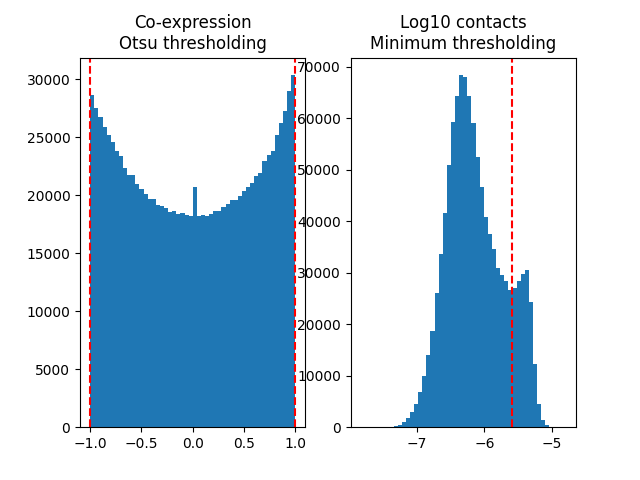

Text(0.5, 1.0, 'Log10 contacts\nMinimum thresholding')

In [32]:
%matplotlib notebook

fig, ax = plt.subplots(1, 2)

coexpr_thr = np.percentile(hr_clean_intra.coexpr.abs(), 99.95)
ax[0].hist(hr_clean_intra.coexpr, 50)
ax[0].axvline(coexpr_thr, ls='--', c='r')
ax[0].axvline(-coexpr_thr, ls='--', c='r')

contacts_thr = filters.threshold_minimum(np.log10(hr_clean_intra.ctl_contacts + hr_clean_intra.inf_contacts))
ax[1].hist(np.log10(hr_clean_intra.ctl_contacts + hr_clean_intra.inf_contacts), 50)
ax[1].axvline(contacts_thr, ls='--', c='r')
ax[0].set_title("Co-expression\nOtsu thresholding")
ax[1].set_title("Log10 contacts\nMinimum thresholding")

If we check out the annotations of genes that pass both thresholds, we get one chromatin organization modifier protein, along with a bunch of metabolism genes:

In [184]:
%matplotlib notebook
sub_pos = hr_clean_intra.loc[
    (hr_clean_intra.coexpr.abs() > coexpr_thr) &
    (np.log10(hr_clean_intra.ctl_contacts + hr_clean_intra.inf_contacts) > contacts_thr),
    :
]
sub_acc = np.unique(pd.concat([sub_pos.accession1, sub_pos.accession2]))
ga = np.unique([i for i in liftover.loc[liftover.accession.isin(sub_acc), 'desc'].tolist() if i != 'hypothetical protein'])

for g in ga:
    print(g)

4alpha-methyl-sterol C4-methyl-oxidase
ABC transporter, ATPbinding domain containing protein
AMPbinding enzyme domain containing protein
ATPase, AAA domain containing protein
ATPdependent DNA ligase domain containing protein
ApaG, putative
DEADbox ATP-dependent RNA helicase 35B, putative
DNA mismatch repair protein msh2, putative
DnaJ domain containing protein
EF hand domain containing protein
Fbox domain containing protein
GATA zinc finger domain containing protein
HEAT repeat domain containing protein
Inositol 1,4,5trisphosphate receptor type 2, putative
K+ channel protein
LIM domain containing protein
Lglutamine synthetase
LysM domain containing protein
MORN repeatcontaining protein
MaoClike dehydratase domain containing protein
MaoClike domain containing protein
Nacetylglucosaminyl-phosphatidylinositol biosynthetic protein gpi1, putative
P21Rho-binding domain containing protein
Peptide-aspartate beta-dioxygenase
RAB11B protein, putative
RFX DNA-binding domain containing protein
Ras

### Clustering

Li et al divided differentially expressed genes into clusters based on their expression pattern during infection.
I will do the same and see  if the cluster composition of highly contacting genes is different from the rest of the genome. 

Genes are first filtered to include only those that are differentially expressed for at least one timepoint.

In [233]:
time_expr = pd.read_csv('data/output/diff_expr/expr_vs_time.tsv', sep='\t')
# Filter to keep only genes DE for at least one timepoint
max_de = time_expr.groupby('accession')['log2FoldChange'].agg(lambda x: max(abs(x)))
time_expr = time_expr.loc[time_expr.accession.isin(max_de[max_de > 2].index)].reset_index(drop=True)
# Transform each timepoint into a feature
texp_wide = (
    time_expr
    .loc[:, ['accession', 'log2FoldChange', 'time']]
    .pivot_table(index=['accession'], columns='time', values='log2FoldChange')
    .reset_index()
    .dropna()
)
time_expr

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,time
0,ACA1_000590,267.554735,-2.279320,0.379138,-6.011844,1.834253e-09,1.406650e-08,24
1,ACA1_001270,25.771749,2.754854,0.520513,5.292571,1.206086e-07,6.725406e-07,24
2,ACA1_002430,383.813105,2.174247,0.259654,8.373622,5.587374e-17,1.291622e-15,24
3,ACA1_002610,502.496946,2.214771,0.305224,7.256203,3.981073e-13,5.370545e-12,24
4,ACA1_002740,403.143999,-2.785630,0.538649,-5.171509,2.322106e-07,1.232089e-06,24
...,...,...,...,...,...,...,...,...
4195,ACA1_399840,75.063931,2.504456,0.338702,7.394283,1.421735e-13,1.047748e-10,3
4196,ACA1_399890,2.621086,0.234796,0.542172,0.433066,6.649671e-01,8.901337e-01,3
4197,ACA1_399930,164.561257,0.604066,0.328705,1.837714,6.610459e-02,3.548530e-01,3
4198,ACA1_400000,67.363756,1.013033,0.259622,3.901949,9.542109e-05,3.853781e-03,3


<IPython.core.display.Javascript object>


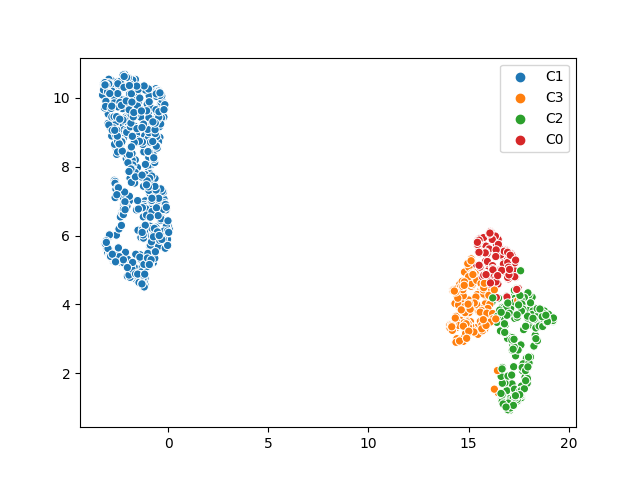

In [234]:
%matplotlib notebook

pca = PCA()
km = KMeans(n_clusters=4)
clus = km.fit_predict(texp_wide.drop('accession', axis=1))
um = umap.UMAP(n_neighbors=50).fit_transform(texp_wide.drop('accession', axis=1))
sns.scatterplot(x=um[:, 0], y=um[:, 1], hue=[f"C{i}" for i in clus])

In [177]:
texp_wide

time,accession,3,8,16,24
0,ACA1_000590,0.193949,-1.642411,-2.522668,-2.279320
1,ACA1_001270,2.085078,1.698436,1.309279,2.754854
2,ACA1_002430,0.665698,1.756149,1.926169,2.174247
3,ACA1_002610,0.963558,1.353200,1.368071,2.214771
4,ACA1_002740,-0.645347,-0.982943,-1.510146,-2.785630
...,...,...,...,...,...
1045,ACA1_399840,2.504456,1.771978,1.675142,0.912049
1046,ACA1_399890,0.234796,0.865425,0.814638,3.548104
1047,ACA1_399930,0.604066,0.408027,1.256082,2.209209
1048,ACA1_400000,1.013033,1.931542,2.408087,2.371009


In [235]:
texp_wide['cluster'] = [f"C{i}" for i in clus]
clus_df = time_expr[['accession', 'log2FoldChange', 'time']].merge(texp_wide[['accession', 'cluster']], how='inner')
clus_df = clus_df.groupby(['cluster', 'time']).agg('mean').reset_index()

In [ ]:
# %matplotlib notebook
fig, ax = plt.subplots(2, 4)
for i, a in enumerate(ax.flat):
    ngenes = (texp_wide.cluster == f'C{i}').sum()
    a.plot(
        clus_df.loc[clus_df.cluster==f'C{i}', 'time'],
        clus_df.loc[clus_df.cluster==f'C{i}', 'log2FoldChange']
    )
    a.set_title(f"C{i}: {ngenes} genes")
    a.set_ylim([-3, 3])

<IPython.core.display.Javascript object>


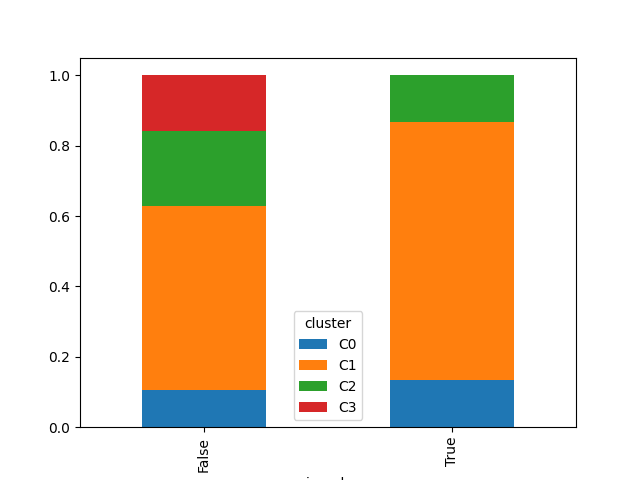

In [238]:
%matplotlib notebook
texp_wide['in_sub'] = texp_wide.accession.isin(sub_acc)
texp_wide.groupby(['in_sub', 'cluster'])['in_sub'].count().groupby('in_sub').apply(lambda x: x / sum(x)).unstack('cluster').plot.bar(stacked=True)

### GO enrichment

One interesting question is: are there specific pathways / class of genes whose contact change compared to the rest of differentially expressed genes.

<IPython.core.display.Javascript object>


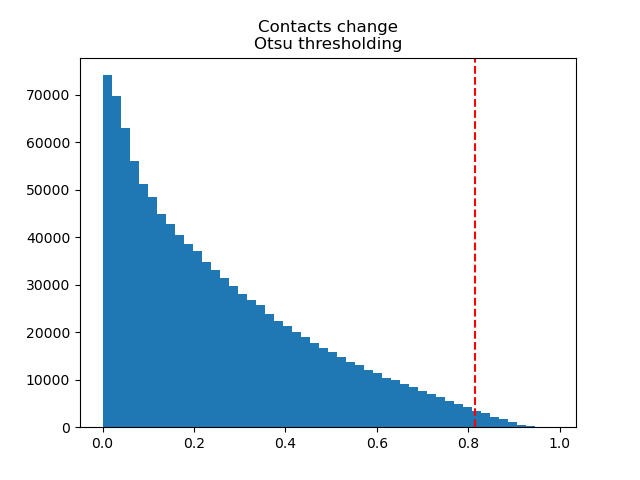

Text(0.5, 1.0, 'Contacts change\nOtsu thresholding')

In [162]:
%matplotlib notebook

change_thr = np.percentile(hr_clean_intra.contacts_change.abs(), 99)
plt.hist(hr_clean_intra.contacts_change.abs(), 50)
plt.axvline(change_thr, ls='--', c='r')
plt.title("Contacts change\nOtsu thresholding")

Now let's subset the top 5% highest contact change gene pairs, which are also above coexpression threshold.

In [35]:
pairs_3d_change = hr_clean_intra.loc[
    (hr_clean_intra.contacts_change.abs() > change_thr) &
    (hr_clean_intra.coexpr.abs() > coexpr_thr)
]
genes_3d_change = np.unique(pd.concat([pairs_3d_change.accession1, pairs_3d_change.accession2]))

NameError: name 'change_thr' is not defined

In [164]:
print(f"{pairs_3d_change.shape[0]} gene pairs filtered, yielding {genes_3d_change.shape[0]} unique genes.")

5835 gene pairs filtered, yielding 4854 unique genes.


Now let's merge these set of genes with DE genes at 8h pi.

In [165]:
sig_3d = sig_expr.loc[sig_expr.accession.isin(genes_3d_change), 'accession'].tolist()
sig = sig_expr.accession.tolist()

In [166]:
print(f'There are {len(sig_3d)} genes with 3D changes out of {len(sig)} DE genes')

There are 640 genes with 3D changes out of 1759 DE genes


Next we need to load GO annotations for each gene and count the number of genes with/without each GO term in both sets

In [167]:
mapping = pd.read_csv('data/tmp/liftoff/neff_c3_gene_mapping.tsv', sep='\t', header=None, names=['neff', 'c3'])
full_annot = pd.read_csv(
    'data/input/annotations/c3_annotations/Acanthamoeba_castellanii.gff3',
    sep='\t',
    header=None,
    comment='#',
    usecols=[2, 8],
    names=['type', 'attrs'],
)
full_annot = full_annot.loc[full_annot['type'] == 'mRNA', :]
full_annot['GO'] = full_annot['attrs'].str.replace(r'.*Ontology_term=([^;]*);.*', r'\1')
full_annot.GO[~full_annot.GO.str.contains('GO:')] = ""
full_annot['c3'] = full_annot['attrs'].str.replace(r'.*Parent=([^;]*);.*', r'\1')
full_annot = full_annot.merge(mapping, how='inner', on='c3')
full_annot.GO = full_annot.GO.apply(lambda g: [x for x in g.split(',') if x != ''])
full_annot

,type,attrs,GO,c3,neff
0,mRNA,ID=FUN_000001-T1;Parent=FUN_000001;product=hyp...,"[GO:0005525, GO:0003924, GO:0007165, GO:0016020]",FUN_000001,ACA1_272090
1,mRNA,ID=FUN_000002-T1;Parent=FUN_000002;product=hyp...,[],FUN_000002,ACA1_272100
2,mRNA,ID=FUN_000004-T1;Parent=FUN_000004;product=hyp...,[],FUN_000004,ACA1_272220
3,mRNA,ID=FUN_000006-T1;Parent=FUN_000006;product=hyp...,[],FUN_000006,ACA1_272240
4,mRNA,ID=FUN_000007-T1;Parent=FUN_000007;product=hyp...,[],FUN_000007,ACA1_272250
...,...,...,...,...,...
12727,mRNA,ID=FUN_003557-T1;Parent=FUN_003557;product=hyp...,[],FUN_003557,ACA1_174550
12728,mRNA,ID=FUN_003910-T1;Parent=FUN_003910;product=hyp...,[GO:0006629],FUN_003910,ACA1_372580
12729,mRNA,ID=FUN_004347-T1;Parent=FUN_004347;product=hyp...,[GO:0016021],FUN_004347,ACA1_171510
12730,mRNA,ID=FUN_004794-T1;Parent=FUN_004794;product=hyp...,[],FUN_004794,ACA1_243840


In [168]:
def genes2go(genes, df):
    gos = df.GO[df.neff.isin(genes)].reset_index(drop=True)
    gos, go_counts =  np.unique(np.concatenate(gos), return_counts=True)
    go_counts = {t: c for t, c in zip(gos, go_counts)}
    return go_counts


In [169]:
all_gos = np.unique(np.concatenate(full_annot.GO))
go_terms = pd.DataFrame({'GO': all_gos, 'fg_y': 0, 'fg_n': 0, 'bg_y': 0, 'bg_n': 0})
go_terms = go_terms.set_index('GO')

In [171]:
for g, c in genes2go(sig, full_annot).items():
    go_terms.loc[g, 'bg_y'] += 1
for g, c in genes2go(sig_3d, full_annot).items():
    go_terms.loc[g, 'fg_y'] += 1
go_terms.fg_n = len(sig_3d) - go_terms.fg_y
go_terms.bg_n = len(sig) - go_terms.bg_y

In [172]:
go_terms['odds_ratio'] = (go_terms.fg_y/go_terms.fg_n)/(go_terms.bg_y/go_terms.bg_n)

In [175]:
go_terms.loc[~np.isnan(go_terms.odds_ratio), :].sort_values('fg_y')

,fg_y,fg_n,bg_y,bg_n,odds_ratio
GO,,,,,
GO:0000062,0,640,1,1758,0.000000
GO:0009225,0,640,1,1758,0.000000
GO:0009081,0,640,1,1758,0.000000
GO:0009055,0,640,1,1758,0.000000
GO:0008757,0,640,1,1758,0.000000
...,...,...,...,...,...
GO:0004470,1,639,1,1758,2.751174
GO:0004471,1,639,1,1758,2.751174
GO:0004478,1,639,1,1758,2.751174


Well this doesn't work because there is not enough occurences of any single GO term in our gene sets. This is due to the relatively low proportion of annotated genes, and the small size of gene sets.

Instead we'll look specifically at genes with annotations of interest and see if they have unusual 3D changes

/home/cyril/.local/share/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>


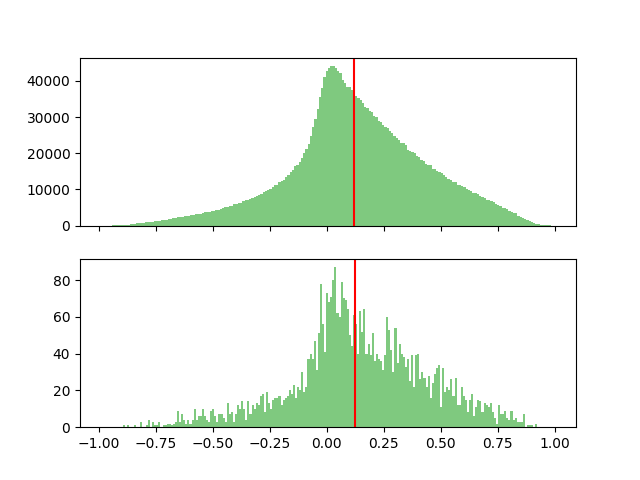

In [108]:
%matplotlib notebook
def hist_term(term='small GTPase'):
    acc_term = liftover.loc[liftover.desc.apply(lambda x: term in x), 'accession']
    nnz_hic = p_hic.loc[(p_hic.ctl_contacts > 0) & (p_hic.inf_contacts) > 0, :]
    nnz_hic['prop_change'] = (nnz_hic.inf_contacts - nnz_hic.ctl_contacts) / (nnz_hic.inf_contacts + nnz_hic.ctl_contacts)
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].hist(nnz_hic.loc[~(nnz_hic.accession1.isin(acc_term) | nnz_hic.accession2.isin(acc_term)), 'prop_change'], 200)
    ax[0].axvline(
        np.median(
            nnz_hic.loc[~(nnz_hic.accession1.isin(acc_term) | nnz_hic.accession2.isin(acc_term)), 'prop_change']
        ),
        c='red'
    )
    ax[1].hist(nnz_hic.loc[nnz_hic.accession1.isin(acc_term) | nnz_hic.accession2.isin(acc_term), 'prop_change'], 200)
    ax[1].axvline(
        np.median(
            nnz_hic.loc[nnz_hic.accession1.isin(acc_term) | nnz_hic.accession2.isin(acc_term), 'prop_change']
        ),
        c='red'
    )
    plt.show()
hist_term()

1

### SImple DE analysis
Instead of using all 4 timepoints and working with pairs of genes, here I try a simpler path.
For each gene, I just use the highest contact value (most frequently interacting neighbour).
I then compare this change in interaction during infection (5h vs uninfected) with the differential expression at 8h p.i. (vs 0)

In [236]:
# Get the mate gene with highest contacts for each gene
high_val = hic_mat.max(axis=0)
high_mate = np.array(ord_genes)[hic_mat.argmax(axis=0)]
dc = pd.DataFrame({'accession': ord_genes, 'mate': high_mate})

# Extract the upper triangle matrix
lower = p_hic.accession2 < p_hic.accession1
full_hic = p_hic.loc[:, ['accession1', 'accession2', 'ctl_contacts', 'inf_contacts']]
full_hic.loc[
    lower, ['accession1', 'accession2']
] = full_hic.loc[
    lower, ['accession2', 'accession1']
].values

# Extract contact values for best-mate pairs
dc = dc.merge(full_hic, left_on=['accession', 'mate'], right_on=['accession1', 'accession2'], how='left').drop(columns=['accession1', 'accession2'])
dc = dc.merge(full_hic, left_on=['accession', 'mate'], right_on=['accession2', 'accession1'], how='left').drop(columns=['accession1', 'accession2'])
dc.ctl_contacts_x[dc.ctl_contacts_x.isnull()] = dc.ctl_contacts_y[dc.ctl_contacts_x.isnull()]
dc.inf_contacts_x[dc.inf_contacts_x.isnull()] = dc.inf_contacts_y[dc.inf_contacts_x.isnull()]
dc = dc.drop(
    columns=['inf_contacts_y', 'ctl_contacts_y']
).rename(
    columns={'ctl_contacts_x': 'ctl_contacts', 'inf_contacts_x': 'inf_contacts'}
)
dc = dc.merge(diff_expr, on='accession', how='inner')
dc = dc.dropna()
dc['prop_change'] = (dc['inf_contacts'] - dc['ctl_contacts']) / (dc['inf_contacts'] + dc['ctl_contacts'])
# add chromosomal coordinates of genes
dc = dc.merge(liftover.loc[:, ['chrom', 'start', 'end', 'accession']], on='accession', how='left')

/home/cyril/.local/share/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cyril/.local/share/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


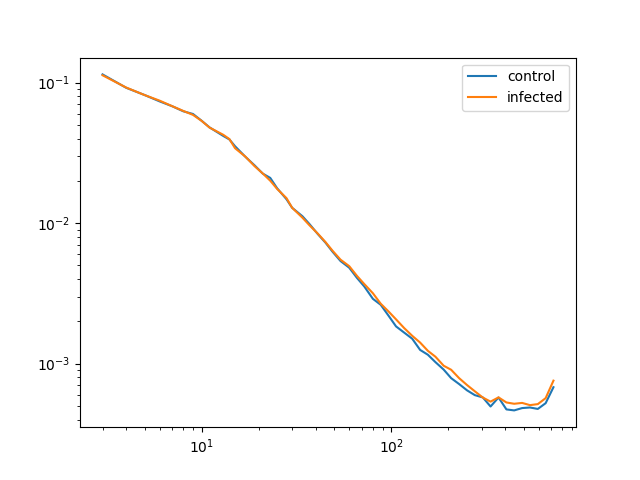

In [226]:
%matplotlib notebook
from hicstuff.hicstuff import distance_law_from_mat
x_ctl, y_ctl = distance_law_from_mat(clr_ctl.matrix(sparse=True, balance=False).fetch('scaffold_4'))
x_inf, y_inf = distance_law_from_mat(clr_inf.matrix(sparse=True, balance=False).fetch('scaffold_4'))
first = 3
x_ctl = x_ctl[first:]
y_ctl = y_ctl[first:]
x_inf = x_inf[first:]
y_inf = y_inf[first:]
plt.loglog(x_ctl, y_ctl/np.sum(y_ctl), label='control')
plt.loglog(x_inf, y_inf/np.sum(y_inf), label='infected')
plt.legend()



### Border change vs expression

Here, I check if gene expression changes are associated with changes in the intensity of the closest domain border.

In [244]:
# Use asof merge borders and differential contacts dataframes to assign the closest border to each gene
borders = pd.read_csv('data/output/pareidolia/borders_change_infection_time.tsv', sep='\t')
dc = pd.merge_asof(
    dc.sort_values('start'),
    borders.loc[:, ['chrom1', 'start1', 'diff_score']].sort_values('start1'),
    left_by='chrom',
    left_on='start',
    right_by='chrom1',
    right_on='start1'
)


<IPython.core.display.Javascript object>


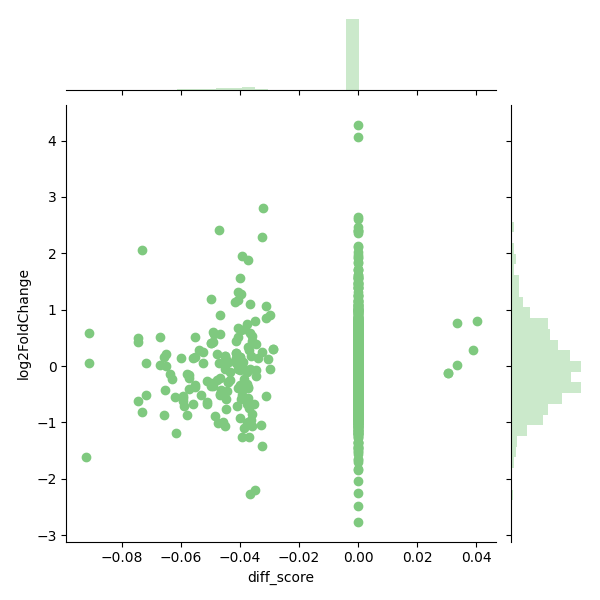

In [246]:
%matplotlib notebook
sns.jointplot(dc.diff_score, dc.log2FoldChange)

In [256]:
%matplotlib notebook
changed = dc.loc[dc.diff_score != 0, :].dropna()
ss.pearsonr(changed.diff_score, )

(-0.04748704963307136, 0.5434875978278387)

#### Unsupervised exploration of gene expression

In [83]:
%matplotlib notebook
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA()
pcs = pca.fit_transform(expr_mat)
sns.jointplot(pcs[:, 0], pcs[:, 1])

NameError: name 'expr_mat' is not defined

In [57]:
import umap
um = umap.UMAP(n_neighbors=50)

embd = um.fit_transform(expr_mat)

<IPython.core.display.Javascript object>


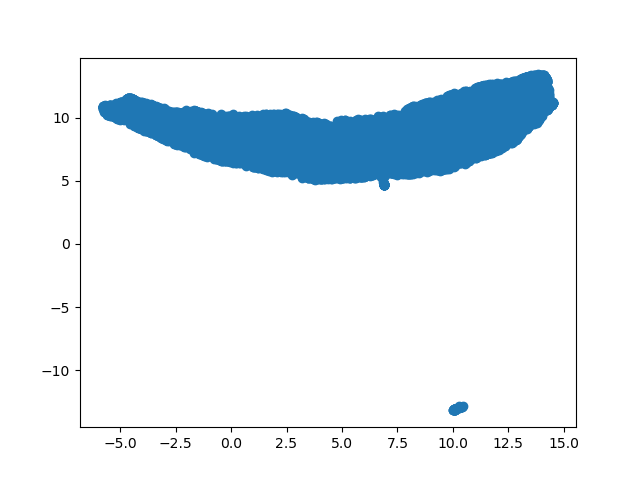

In [58]:
%matplotlib notebook
plt.scatter(embd[:, 0], embd[:, 1])

In [68]:
isolated_genes = np.where(embd[:, 1] < 0)[0]
isolated_names = expr_mat.iloc[isolated_genes, :].index.values
liftover.loc[liftover.accession.isin(isolated_names), :]

,chrom,type,start,end,attr,accession,desc
18894,scaffold_10,gene,813285,813521,ID=gene:ACA1_070310;biotype=protein_coding;des...,ACA1_070310,hypothetical protein
20216,scaffold_10,gene,1043662,1046264,ID=gene:ACA1_069420;biotype=protein_coding;des...,ACA1_069420,RhoGEF domain containing protein
43682,scaffold_14,gene,280896,281176,ID=gene:ACA1_377970;biotype=protein_coding;des...,ACA1_377970,hypothetical protein
45482,scaffold_14,gene,692534,694948,ID=gene:ACA1_110070;biotype=protein_coding;des...,ACA1_110070,"acetyltransferase, GNAT family"
57940,scaffold_16,gene,1169311,1170642,ID=gene:ACA1_254010;biotype=protein_coding;des...,ACA1_254010,hypothetical protein
59898,scaffold_17,gene,351656,352379,ID=gene:ACA1_224710;biotype=protein_coding;des...,ACA1_224710,universal stress domain containing protein
70934,scaffold_18,gene,1146599,1146811,ID=gene:ACA1_073840;biotype=protein_coding;des...,ACA1_073840,hypothetical protein
78522,scaffold_2,gene,5825,7171,ID=gene:ACA1_152400;biotype=protein_coding;des...,ACA1_152400,hypothetical protein
79580,scaffold_2,gene,223910,225189,ID=gene:ACA1_373940;biotype=protein_coding;des...,ACA1_373940,tetratricopeptide repeat domain containing pro...
101212,scaffold_21,gene,812315,813048,ID=gene:ACA1_275030;biotype=protein_coding;des...,ACA1_275030,hypothetical protein


<IPython.core.display.Javascript object>


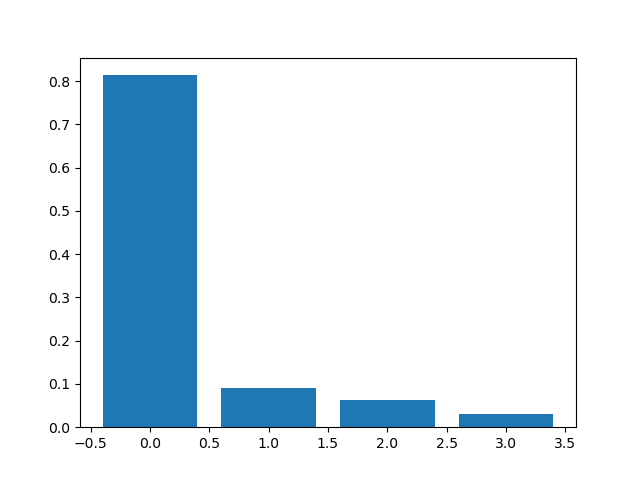

<BarContainer object of 4 artists>

In [137]:
%matplotlib notebook
plt.bar(range(pcs.shape[1]), pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


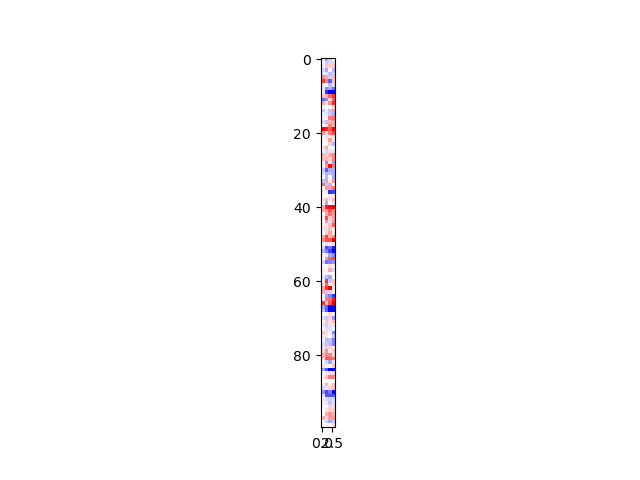

In [150]:
%matplotlib notebook
plt.imshow(expr_mat.to_numpy()[:100],cmap='bwr', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


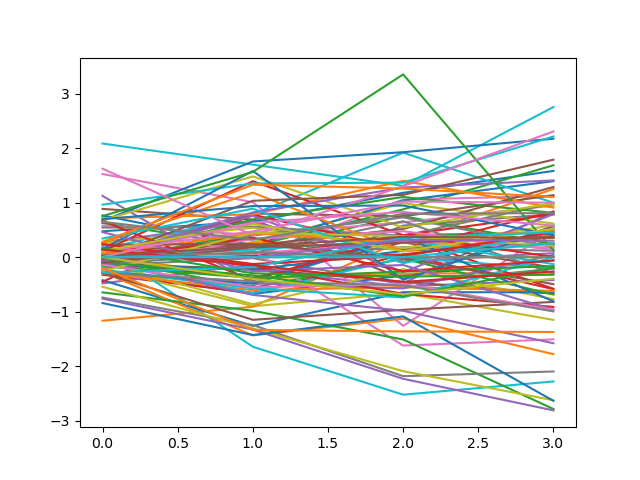

In [152]:
%matplotlib notebook
plt.plot(expr_mat.to_numpy()[:100].T)

#### Side note: Matrix around sirtuin gene sir6f

Below is an overview of the Hi-C contact map ratio of this gene's chromosome during infection.

In [31]:
import serpentine as serp
sir = sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]
sir_pos = clr_inf.extent(f'{sir.chrom.values[0]}:{int(sir.start.values[0])}-{int(sir.end.values[0])}')[0]
sir_pos -= clr_inf.extent(sir.chrom.values[0])[0]
sir_ctl = clr_ctl.matrix(balance=False).fetch(sir.chrom.values[0])
sir_inf = clr_inf.matrix(balance=False).fetch(sir.chrom.values[0])
sA, sB, sk = serp.serpentin_binning(sir_inf, sir_ctl, parallel=1, triangular=True)

2020-11-19 18:23:43.119351 Starting 10 binning processes...
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106470 (66.58744801275837 %)
2	 Total serpentines: 36715 (22.96194377560274 %)
3	 Total serpentines: 13272 (8.300447168454298 %)
4	 Total serpentines: 5607 (3.5066762562931926 %)
5	 Total serpentines: 3235 (2.0232027267894557 %)
6	 Total serpentines: 2528 (1.5810375558960568 %)
7	 Total serpentines: 2387 (1.4928546858876137 %)
8	 Total serpentines: 2373 (1.4840989399293287 %)
9	 Total serpentines: 2373 (1.4840989399293287 %)
9	 Over: 2020-11-19 18:23:46.677558
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106431 (66.56305700616029 %)
2	 Total serpentines: 36734 (22.973826573688985 %)
3	 Total serpentines: 13239 (8.27980862440977 %)
4	 Total serpentines: 5602 (3.5035492041652336 %)
5	 Total serpentines: 3200 (2.0013133618937426 %)
6	 Total serpentines: 2515 (1.5729072203633634 %)
7	 Total serpentines: 2364 (1.4784702460990025 %)
8	 Total serpentines: 23

<IPython.core.display.Javascript object>


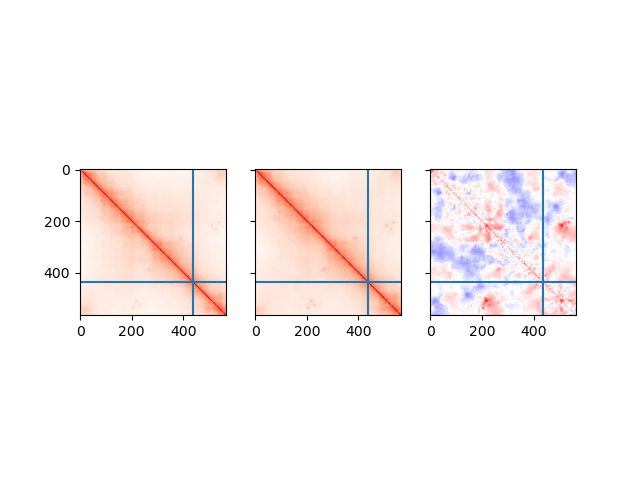

In [32]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(np.log(sA), cmap='Reds')
ax[1].imshow(np.log(sB), cmap='Reds')
ax[2].imshow(sk, cmap='bwr')
for i in range(3):
    ax[i].axvline(sir_pos)
    ax[i].axhline(sir_pos)


Now, we will compare differential looping results from pareidolia with differential expression data.

In [34]:
loops_diff = pd.read_csv(
    'data/output/pareidolia/loops_change_infection_time.tsv',
    sep='\t',
)
loop24 = loops_diff.loc[loops_diff.chrom1 == 'scaffold_24', :]
start24 = clr_inf.extent('scaffold_24')[0]
loop24.bin1 -= start24
loop24.bin2 -= start24

<IPython.core.display.Javascript object>


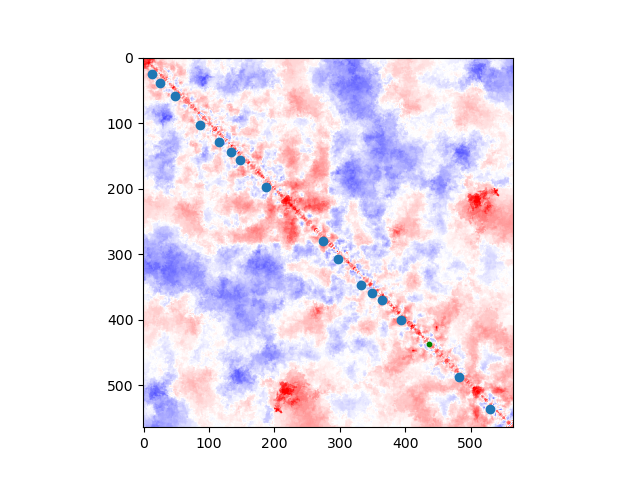

In [39]:
%matplotlib notebook
plt.imshow(sk - sk.mean(), cmap='bwr', vmin = -1, vmax=1)
plt.scatter(loop24.bin1, loop24.bin2)
s = clr_inf.extent('scaffold_24:875568-875568')[0] - start24
plt.scatter(s, s, s=10, c='green')